# Derivativos de Ações e Commodities
##  Implementando Uma Estratégia Replicante 
<sub>Uirá Caiado. 11 de Maio, 2016<sub>

#### Resumo

_Neste projeto vou implementar uma estratégia de hedging dinâmico auto-financiável que replique o payoff de diferentes derivativos. Devido à natureza aleatória do ativo objeto dos contratos testados, este será modelado como um processo estocástico. Uma vez implementado o modelo, será realizada um série de simulações para estudar a efetividade da estratégia._

## 1. Introdução

Nesta sessão dou uma breve descrição do que é uma EDE e declaro o problema que será abordado.

### 1.1. Equações Diferenciais Estocásticas

Devido à incerteza inerente ao mercado financeiro, é necessário levar em conta uma flutuação aleatória nos modelos criados para descrever diferentes instrumentos. Para tanto, frequentemente assume-se o comportamento de um ativo como sendo um [processo estocático](https://en.wikipedia.org/wiki/Stochastic_process). 

Como bem explicado neste [post](http://math.stackexchange.com/questions/1470686/in-laymans-terms-what-is-a-stochastic-process), um processo estocástico é uma maneira de representar como alguma coisa se desenvolve ao longo do tempo. A cada unidade de tempo, o ativo pode assumir uma de muitas posições possíveis, e cada uma destas posições tem uma probabilidade associada. Ainda que não seja possível antecipar qual trajeto o ativo vai seguir, é possível inferir quais caminhos são possíveis baseado nesta dinâmica.

Processos estocásticos são de grande valia quando não se sabe exatamente as regras que regem esta evolução ou quando extrair tais regras com exatidão ou é muito complicado ou muito caro computacionalmente. Assim, frequentemente se utiliza alguma fonte de aleatoriadade para ajudar a descrever a dinâmica de um ativo. Aqui entram as EDEs. \cite{Wilmont} oferece a seguinte intuição sobre a forma geral de Equações Diferenciais Estocásticas (EDE):

$$\mathrm{d}\, Alguma\,Coisa = Deterministico\,\mathrm{d}t + Aleatório\,\mathrm{d}X $$


Onde $Alguma\,Coisa$ é o que se quer modelar (como preço de uma ação, quantidade de pessoas chegando em um hospital e etc), $Deterministico$ uma função que descreve como  $Alguma\,Coisa$ muda quando se retira a incerteza e $Aleatório$ outra função que descreve quão incerto $Alguma\,Coisa$ coisa é e $X$ é uma variável aleatória que pode ter distribuição Normal Padrão, por exemplo.

### 1.1. O Problema

Considerando um ativo-objeto cujo a dinâmica do preço satisfaz a seguinte EDE:

$$\frac{\mathrm{d} S_t}{S_t}=\mu\cdot \mathrm{d}t + \sigma\cdot \mathrm{d}W_{t}$$

Será vendido um derivativo com característica européia cujo payoff é descrito por uma função qualquer $V_T=V(T, S_T)$, onde $T$ é o vencimento do derivativo. $S_T$ é o preço do ativo-objeto em $T$ e é possível negociar qualquer quantidade dele em qualquer instante. Não há custo de transação (corretagem, emolumento, bid-ask spread, etc) e posições vendidas a descoberto no subjacente são permitidas, não havendo custos associados.

Pede-se que se implemente uma estratégia dinâmica de hedging auto-financiável que replique o payoff do derivativo vendido. A estratégia replicante será rebalanceada $N$ vezes (incluíndo a carteira inicial).

A simulação deve ser feita para os payoffs abaixo. $K$ é o Strike da opção.
- $V(T, S_T)=ln(S_T)$
- $V(T, S_T)=(ln(S_T))^2$
- $V(T, S_T)=(S_T-K)^2$
- $V(T, S_T)=\mathbf{1}_{S_T > K}$
- $V(T, S_T)=max(S_T-K, 0)$


## 2. Simulando o Ativo Base

Para realizar a simulação, implementarei o processo estocástico do ativo-objeto, que segue um Movimento Browniano Geométrico. Desta forma, preciso discretizar o processo e tenho duas opções para isso: ou encontro a solução para a EDE porposta, que resultará no [processo estocástico desejado](https://en.wikipedia.org/wiki/Geometric_Brownian_motion); ou uso [método de Euler](http://www.columbia.edu/~mh2078/MCS04/MCS_SDEs.pdf). O último, apesar de ser apenas uma aproximação do processo, tem a a vantagem de poder ser aplicada à qualquer Equação diferencial Estocástica (\cite{Wilmont}). Nas próximas subseções vou demonstrar e implementar cada modelo. 

### 2.1. A Solução Exata do Modelo

Seguindo as notas de aula e reescrevendo a dinâmica por conveniência, tenho que

\begin{equation}
    \begin{aligned}
    \frac{\mathrm{d} S_t}{S_t} &= \mu\cdot \mathrm{d}t + \sigma\cdot \mathrm{d}W_{t}
    \end{aligned}
\end{equation}


Que corresponde a forma derivada da integral estocástica:


\begin{equation}
    \begin{aligned}
    \int_{t}^{T}{\frac{\mathrm{d} S_t}{S_t}} &= \int_{t}^{T}{\mu\cdot \mathrm{d}t} + \int_{t}^{T}{\sigma\cdot \mathrm{d}W_{t}} 
    \end{aligned}
\end{equation}



Considerando o [Teorema de Ito-Doeblin](https://en.wikipedia.org/wiki/Itô%27s_lemma) (Lemma de Ito) sendo da forma abaixo

\begin{equation}
    \begin{aligned}
    \mathrm{d} f(t, S_t) = \frac{\mathrm{\partial} f}{\partial t} \mathrm{d} t + \frac{\mathrm{\partial} f}{\partial S_t} \mathrm{d} S_t + \frac{1}{2} \frac{\mathrm{\partial^2} f}{\mathrm{\partial} S_{t}^{2}} (\mathrm{d} S_t)^2
    \end{aligned}
\end{equation}

Se definir uma função $f(S_t) = ln(S_t)$, posso aplicar o Lema de Ito sobre ela. Dado que $(\mathrm{d} t)^2 = \mathrm{d} t \cdot \mathrm{d} X = 0$, e que $(\mathrm{d} S_t)^2 = \sigma^2  \cdot S_{t}^{2} \cdot \mathrm{d} t$. Como não há termos dependentes de $t$ em $f$, não precisarei do termo relacionado a $\mathrm{d} t$. Assim ficou com:

\begin{equation}
    \begin{aligned}
    \mathrm{d} f(t, S_t) &= \frac{\mathrm{\partial} f}{\partial S_t} \mathrm{d} S_t + \frac{1}{2} \frac{\mathrm{\partial^2} f}{\mathrm{\partial} S_{t}^{2}} (\mathrm{d} S_t)^2 \\
    &= \frac{1}{S_t} \cdot \mathrm{d} S_t - \frac{\sigma^2}{2} \cdot S_{t}^{2} \cdot \frac{1}{S_{t}^{2}} \cdot  \mathrm{d} t 
    \end{aligned}
\end{equation}

Integrando dos instantes $t$ até $T$, obtenho:

\begin{equation}
    \begin{aligned}
    \int_{t}^{T} \mathrm{d} f(t, S_t) &= \int_{t}^{T} \frac{1}{S_t} \cdot \mathrm{d} S_t - \int_{t}^{T} \frac{\sigma^2}{2} \cdot \mathrm{d} t \\
    \int_{t}^{T} \frac{\mathrm{d} S_t}{S_t} &= \int_{t}^{T} \mathrm{d} f(t, S_t) + \int_{t}^{T} \frac{\sigma^2}{2} \cdot \mathrm{d} t \\
    &= f(S_T) - f(S_t) + \frac{\sigma^2}{2} \cdot (T - t) \\
    &= ln(S_T) - ln(S_t) + \frac{\sigma^2}{2} \cdot (T - t) \\
    &= ln(S_T/S_t) + \frac{\sigma^2}{2} \cdot (T - t)
    \end{aligned}
\end{equation}

Logo, substituíndo este resultado na integral estocástica da dinâmica da ação, chego que:

\begin{equation}
    \begin{aligned}
    ln(S_T/S_t) + \frac{\sigma^2}{2} \cdot (T - t) &= \int_{t}^{T}{\mu\cdot \mathrm{d}t} + \int_{t}^{T}{\sigma\cdot \mathrm{d}W_{t}} \\
     ln(S_T/S_t) + \frac{\sigma^2}{2} \cdot (T - t) &= \mu\cdot (T - t) + \sigma \cdot (W_{T} - W_{t})
    \end{aligned}
\end{equation}

Por fim, lembrando que o $W_t$ é um processo de Winer e possui incrementos independentes, estacionários e distribuição $N(0, t)$ por definição, posso considerar que $W_t - W_s = W_{t-s}$. Termino com:

\begin{equation}
    \begin{aligned}
     ln(S_T/S_t) + \frac{\sigma^2}{2} \cdot (T - t) &= \mu\cdot (T - t) + \sigma \cdot W_{T-t} \\
     ln(S_T/S_t) &= \left (\mu - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W_{T-t} \\
     S_T &= S_t \cdot e^{ \left (\mu - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W_{T-t}}
    \end{aligned}
\end{equation}

Onde $W_{T-t} = \sqrt{T-t} \cdot \epsilon_t$. A última equação é a solução exata desta EDE e poderia ser utilizada na simulação. Abaixo, vou implementa-la e testá-la.

In [210]:
# bibliotecas necessarias
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

In [211]:
class StochasticProcess(object):
    '''
    A general representation of a Stochastic Process
    '''
    def __init__(self, f_sigma, f_time, f_steps, b_random_state = True):
        '''
        Initialize a StochasticProcess object. Save all parameters as attributes
        '''
        self._f_sigma = 0
        # guarda parametros
        self.f_sigma = f_sigma
        self.f_time = f_time
        self.f_steps = f_steps
        self.b_random_state = b_random_state
        # checa se seta um seed para o random state
        if not b_random_state:
            np.random.seed(0)
    
    @property
    def f_sigma(self):
        '''
        Return the variance of the process
        '''
        return self._f_sigma
    
    @f_sigma.setter
    def f_sigma(self, f_value):
        '''
        set the f_sigma attribute. ensure that the number is positive
        :param f_value: float. A non negative float number
        '''
        # TODO: I need to check this property
        assert f_value>=0., u"A volatilidade deve ser positiva"
        self._f_sigma = f_value
        
    def _random_number(self):
        '''
        Return a float drown from a distribution
        and standard deviation 1
        '''
        raise NotImplementedError()
    
    def __call__(self):
        '''
        Return a random drow from the Stochastic Process
        '''
        raise NotImplementedError()
    

In [212]:
class WienerProcess(StochasticProcess):
    '''
    A representation of a Wiener process, also called Brownian motion.
    '''
    def __init__(self, f_sigma, f_time, f_steps, b_random_state = True):
        '''
        Initialize a WienerProcess object. Save all parameters as attributes
        :param f_sigma: float. The standard deviation of ALL distribution
        :param f_time: float. the time at each step, in years
        :param f_steps: float. number of steps to simulate for
        :*param f_random_state: float. Random state to be used to reproduciability
        '''
        super(WienerProcess, self).__init__(f_sigma, f_time, f_steps, b_random_state = True)
    
    def _random_number(self):
        '''
        Return a float of drown from a normal distribution with mean 0 and standard
        deviation 1
        '''
        return np.random.standard_normal()
    
    def __call__(self):
        '''
        Return a random drow from the Wiener process with mean 0 and variance t
        '''
        delta_t = self.f_time/self.f_steps
        sqrt_delta_sigma = math.sqrt(delta_t) * self.f_sigma
        return sqrt_delta_sigma * self._random_number()

In [213]:
class GeometricBrownianMotion(StochasticProcess):
    '''
    A generic representation of a Geometric Brownian Motion (GBM). Besides de variance,
    this process might present a drift
    '''
    def __init__(self, f_s0, f_sigma, f_time, f_steps, b_random_state=True, f_r=None, f_mu=None):
        '''
        Initialize a GeometricBrownianMotion object. Save all parameters as attributes
        :param f_s0: float. The initial price of the process
        :param f_sigma: float. The standard deviation of ALL distribution
        :param f_time: float. the time at each step, in years
        :param f_steps: float. number of steps to simulate for
        :*param f_random_state: float. Random state to be used to reproduciability
        :*param f_r: float. risk free interest rate
        :*param f_mu: float. the average return of the process
        '''
        # inicia parametros
        self._original = f_s0
        self.f_St = f_s0
        self.f_mu = f_mu
        self.f_r = f_r
        self._current_step = -1
        super(GeometricBrownianMotion, self).__init__(f_sigma, f_time, f_steps,
                                                      b_random_state = True)
        # inicia o processo de winner presente no BGM
        self.wiener_process = None
  
    @property
    def current_step(self):
        '''
        Return the variance of the process
        '''
        return self._current_step
    
    @current_step.setter
    def current_step(self, i_value):
        '''
        set the current_step attribute. ensure that the current step is
        not greater than the total steps defined to the process
        :param i_value: integer. A increment step to the current path
        '''
        self._current_step = i_value
        if self._current_step > self.f_steps:
            self._current_step = 0
            self.f_St = self._original
        
        
    def __call__(self):
        '''
        Return a PRICE selected from a specif path randomly generated by a
        Geometric Brownian Motion
        '''
        raise NotImplementedError()

In [214]:
class GBM_Exact_Solution(GeometricBrownianMotion):
    '''
    A representation of the Exact solution of a Geometric Brownian Motion (GBM).
    Besides de variance, this process might present a drift
    '''
    def __init__(self, f_s0, f_mu, f_sigma, f_time, f_steps, b_random_state = True):
        '''
        Initialize a GBM_Exact_Solution object. Save all parameters as attributes
        :param f_s0: float. The initial price of the process
        :param f_mu: float. the average return of the process
        :param f_sigma: float. The standard deviation of ALL distribution
        :param f_time: float. the time at each step, in years
        :param f_steps: float. number of steps to simulate for
        :*param f_random_state: float. Random state to be used to reproduciability
        '''
        # inicia variaveis da GeometricBrownianMotion
        super(GBM_Exact_Solution, self).__init__(f_s0 = f_s0,
                                                 f_mu = f_mu,
                                                 f_sigma = f_sigma,
                                                 f_time = f_time,
                                                 f_steps = f_steps,
                                                 b_random_state = True)
        # inicia o processo de winner presente no BGM
        self.wiener_process = WienerProcess(f_sigma, f_time, f_steps)      
        
    def __call__(self):
        '''
        Return a PRICE selected from a specif path randomly generated by the
        Exact solution of the Geometric Brownian Motion
        '''
        # seta a quantidade de passos ja dados por esse processo
        # se for maior que limite, retorna para estado inicial e
        # comeca novamente
        self.current_step += 1
        s_entrei = "Nao"
        if self.current_step > 0:
            s_entrei = "Sim"
            # calcula preco pelo movimento browniano geometrico
            dt = self.f_time/self.f_steps
            sigma_pow_mu_delta = (self.f_mu - 0.5 * self.f_sigma**2.0) * dt
            f_log_rtn = sigma_pow_mu_delta + self.wiener_process()
            f_rtn = np.exp(f_log_rtn)
            self.f_St *= f_rtn
            # print self.current_step, self.f_St, s_entrei
        return self.f_St

In [215]:
import time

def do_simulations(MySrochasticProcess, i_nsiml, f_s0, f_mu, f_sigma, f_time, f_steps, f_r=None):
    '''
    Simulate a number of paths using some Stochastic Process and return a dataframe
    with all paths
    :param MySrochasticProcess: StochasticProcess object. The stochastic process used
    :param i_nsiml: integer. the number of paths contructed
    :param f_s0: float. The initial price of the process
    :param f_mu: float. the average return of the process
    :param f_sigma: float. The standard deviation of ALL distribution
    :param f_time: float. the time at each step, in years
    :param f_steps: float. number of steps to simulate for
    '''
    st = time.time()
    # Crio objeto para simulacao
    if f_r:
        gbm = MySrochasticProcess(f_s0=f_s0,
                                 f_r=f_r,
                                 f_sigma=f_sigma,
                                 f_time=f_time,
                                 f_steps=f_steps)
    else:
        gbm = MySrochasticProcess(f_s0=f_s0,
                                 f_mu=f_mu,
                                 f_sigma=f_sigma,
                                 f_time=f_time,
                                 f_steps=f_steps)
    # crio i_nsiml caminhos com f_steps simulacoes
    l = []
    l_aux = []
    for idx in range(int(i_nsiml * (1 + gbm.f_steps))):
        if gbm.current_step==gbm.f_steps:
            l.append(l_aux)
            l_aux = []
        l_aux.append(gbm())
    l.append(l_aux)
    # imprimo tempo e simulacoes
    print ("\nNumero de sorteios: {}".format(idx + 1))
    print ("Levou {:0.2f} segundos".format(time.time() - st))
    # crio dataframe com os passos nas linhas e as simulacoes nas colunas
    df = pd.DataFrame(l).T
    return df

In [216]:
def plot_simulations(df, s_title, f_steps):
    '''
    Plot a line chart to each path in the dataframe passed
    and a vertical histogram summarizing all paths
    :param df: dataframe. the data with all paths simulated
    :param s_title: string. The title of the chart
    :param f_steps: float. the number of steps in the simulation
    '''
    # crio o grid
    sns.set_context(rc={"figure.figsize": (15, 6)})
    g = sns.JointGrid(x=df.columns, y=df.iloc[-1, :].values, size=7)
    g.ax_marg_x.set_visible(False)
    # ploto as linhas
    g.ax_joint.plot(df, linewidth=2)
    g.ax_joint.set_xlim([0, int(f_steps)])
    # ploto o histograma
    g.plot_marginals(sns.distplot, kde=True)
    # arrumo o grafico
    g.fig.suptitle(s_title, fontsize=18, y=0.92)
    g.set_axis_labels("Passo", u"Preço");

Abaixo vou plotar 500 caminhos, cada um com 15 passos. Vou mostrar visualmente as primeiras linhas da matriz criada a checagem.

In [10]:
d_param = {"f_s0": 10.,  # estado inicial do ativo
           "f_mu": 0.25,  # media da dinamica
           "f_sigma": 0.15,  # desvio padrao da dinamica
           "f_time": 0.5,  # tempo decorrido na simulacao
           "f_steps": 15, # quantidade de passos dado entre a e f_time
           "f_r": None  # taxa de juros
           }  
df = do_simulations(GBM_Exact_Solution, 500, **d_param)
df.head()


Numero de sorteios: 8000
Levou 0.10 segundos


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
1,10.516114,10.417640,9.999023,9.867650,9.466941,9.576886,9.879472,10.179919,10.315365,10.436371,...,10.070028,10.132932,9.970941,9.807603,10.223926,10.404373,10.273586,10.412448,10.036947,9.912510
2,10.473088,10.666697,10.325544,9.654302,9.284399,9.738402,10.066762,9.962551,10.511809,10.342705,...,10.337932,10.041622,9.947794,9.350181,10.048353,10.606207,10.417064,10.056867,10.259002,9.845996
3,10.514672,10.347738,9.762017,9.597175,9.322161,9.158756,10.017062,9.797056,10.874814,10.317698,...,10.252876,10.270389,10.333575,9.222661,9.910538,9.870830,10.251493,11.182432,10.022437,10.379630
4,10.260800,10.961822,10.061974,9.749167,9.627013,9.642840,9.806665,9.717659,11.154039,10.208928,...,10.710322,10.484334,10.298487,8.924116,10.073250,10.168819,10.450610,11.267473,10.271566,10.436756


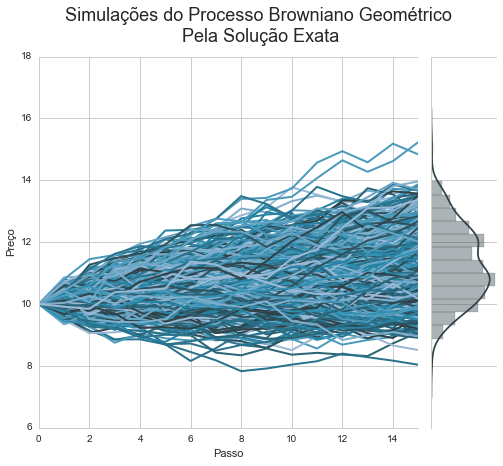

In [11]:
plot_simulations(df,
                 u"Simulações do Processo Browniano Geométrico\n Pela Solução Exata",
                 d_param["f_steps"])

In [12]:
# mostra resumo estatistico do ultimo valor das simulacoes
df_descr = pd.DataFrame(df.iloc[-1, :].describe()).T
df_descr.index = ["values"]
df_descr

,count,mean,std,min,25%,50%,75%,max
values,500,11.265104,1.179955,8.038464,10.355672,11.117979,12.133795,15.232923


Aparentemente a implementação ficou correta e, apesar de estar simulando um passo por vez e dividido todo processo em diferentes classes, o tempo necessário para rodar toda a simulação ficou em um nível aceitável (cerca de 80 milisegundos). Abaixo, vou utilizar toda a estrtutura criada nesta subseção para fazer a simulação pelo método de Euler.


### 2.2. Implementação da Solução Aproximada Pelo Método de Euler

Em aplicações reais, muitas vezes a equação estocástica pode não ter uma solução explícita ou podemos ter dificuldade em determinar os parâmetros do modelo e/ou a distribuição de $W_{t}$. Assim, muitas vezes recorre-se ao método de Euler para discretizar o processo. Neste caso, o método é da forma:

\begin{equation}
    \begin{aligned}
    \hat{X}_{t_{i+1}} = \hat{X}_{t_{i}} + b(t, \hat{X}_{t_i}) \cdot h_i + \sigma(t_i, \hat{X}_{t_i}) \cdot \sqrt{h_i} \cdot \epsilon_i\\
    \left\{\begin{matrix}
        b(t, \hat{X}_{t_i}) &= \mu S_{t_{i}}\\ 
        \sigma(t_i, \hat{X}_{t_i}) &= \sigma S_{t_{i}}\\ 
        h_i &= t_{i+1} - t_i
    \end{matrix}\right.
    \end{aligned}
\end{equation}

Sendo que $\epsilon$ é uma variável aleatória com distribuição normal padrão. Abaixo vou implementar e testar este método

In [217]:
class GBM_By_Euler(GeometricBrownianMotion):
    '''
    A representation of the Geometric Brownian Motion (GBM) simulated using Euler
    Method. Besides de variance, this process might present a drift
    '''
    def __init__(self, f_s0, f_mu, f_sigma, f_time, f_steps, b_random_state = True):
        '''
        Initialize a GBM_Exact_Solution object. Save all parameters as attributes
        :param f_s0: float. The initial price of the process
        :param f_mu: float. the average return of the process
        :param f_sigma: float. The standard deviation of ALL distribution
        :param f_time: float. the time at each step, in years
        :param f_steps: float. number of steps to simulate for
        :*param f_random_state: float. Random state to be used to reproduciability
        '''
        # inicia variaveis da GeometricBrownianMotion
        super(GBM_By_Euler, self).__init__(f_s0=f_s0,
                                           f_mu=f_mu,
                                           f_sigma=f_sigma,
                                           f_time=f_time,
                                           f_steps=f_steps)
        # inicia o processo de winner, que vou dar o nome dos termos da equacao
        self.sigma_sqrt_t_eps = WienerProcess(f_sigma, f_time, f_steps)

    def __call__(self):
        '''
        Return a PRICE selected from a specif path randomly generated by a
        Geometric Brownian Motion
        '''
        # seta a quantidade de passos ja dados por esse processo
        # se for maior que limite, retorna para estado inicial e
        # comeca novamente
        self.current_step += 1
        if self.current_step > 0:
            # calcula preco pelo movimento browniano geometrico
            dt = self.f_time/self.f_steps
            mu_St_dt = self.f_mu * self.f_St * dt
            sigma_St_sqrt_t_eps = self.f_St * self.sigma_sqrt_t_eps()
            self.f_St += mu_St_dt + sigma_St_sqrt_t_eps
            # print self.current_step, self.f_St, s_entrei
        return self.f_St

Realizando o teste com os mesmos parâmetros da simulaçâo anterior, obtenho os seguintes resultados:

In [14]:
d_param = {"f_s0": 10.,  # estado inicial do ativo
           "f_mu": 0.25,  # media da dinamica
           "f_sigma": 0.15,  # desvio padrao da dinamica
           "f_time": 0.5,  # tempo decorrido na simulacao
           "f_steps": 15, # quantidade de passos dado entre a e f_time
           "f_r": None  # taxa de juros
           }
df = do_simulations(GBM_By_Euler, 500, **d_param)
df.head()


Numero de sorteios: 8000
Levou 0.05 segundos


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
1,10.322685,10.264456,9.450168,10.312125,10.255530,10.436647,9.786796,9.931290,9.952677,10.323525,...,10.767730,10.299599,10.356686,9.782162,10.116412,9.629296,9.833701,10.062504,10.248503,10.705830
2,10.101171,10.293800,9.363836,10.414969,10.393092,10.455858,9.556801,10.076890,10.324403,10.186397,...,10.955750,10.526937,10.291900,10.032470,9.890765,9.639253,10.008183,10.225921,10.400660,10.531147
3,10.095567,10.374418,9.573458,10.582164,10.895974,10.369795,9.846075,10.401182,10.398039,10.657965,...,11.361031,10.624004,10.321819,10.069155,9.742425,9.920339,10.749617,10.130267,10.295398,10.612298
4,9.724706,10.231141,9.906968,10.870458,10.899681,10.358649,9.740350,10.482463,10.842610,10.808572,...,11.602789,10.548069,10.319696,9.863423,10.061143,9.633192,10.695378,10.093463,10.351144,10.733868


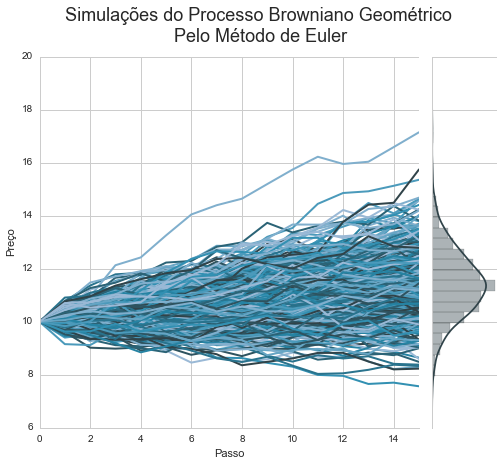

In [15]:
plot_simulations(df,
                 u"Simulações do Processo Browniano Geométrico\n Pelo Método de Euler",
                 d_param["f_steps"])

In [16]:
# mostra resumo estatistico do ultimo valor das simulacoes
df_descr = pd.DataFrame(df.iloc[-1, :].describe()).T
df_descr.index = ["values"]
df_descr

,count,mean,std,min,25%,50%,75%,max
values,500,11.424009,1.257084,7.565741,10.602567,11.381227,12.187256,17.144053


A distribuição final dos valores ficou suficientemente parecida e este método é muito mais genérico e fácil de usar do que resolver uma EDE. Além disso, esta simulação foi um pouco mais rápida que o anterior. Utilizarei o método de Euler quando for implementar a estratégia de replicação. **Um ponto interessante a se notar nas simulações que elas ficaram deslocadas um pouco para cima, o que é esperado, dado que existe um drift na dinâmica**.

## 3. Precificando Opções

Segundo \cite{Wilmont}, o valor justo de uma opção pode ser mostrado como sendo o payoff esperado em seu vencimento. Porém, não o valor sob a expectativa real, que considera a probabilidade real (e geralmente desconhecida) de diferentes eventos acontecerem, mas sim uma outra, [neutra a risco](https://en.wikipedia.org/wiki/Risk-neutral_measure). Assim, espera-se que:

$$preço\, da\, opção = e^{-r(T-t)} \cdot \tilde{E}[payoff(S_T)]$$

Onde $e^{-r(T-t)}$ é o fator de desconto. Nesta seção vou demonstrar rapidamente alguns conceitos importantes no [método de Martingale](https://en.wikipedia.org/wiki/Martingale_pricing) de precificação de opções e implementar as classes necessárias para calcular o preço de cada opção desejada. 

### 3.1. Martingale e Não-Arbitragem

É dito que uma dada sequência de variáveis aleatórias é Martingale quando, em um dado momento, a expectativa sobre o próximo valor dela é o valor observado neste momento. Por tanto, um processo é martingale se 

$$M_n = E_n [M_{n+1}],\qquad n = 0, 1, ..., N-1$$

Quando se precifica uma opção, é interessante que seu subjacente apresente esta característica pois isso é o equivalente a dizer que não é possível a realização de arbitragem utilizando a opção precificada e o ativo no qual ela se baseia.

Como observado nas simulações,  a média da dinâmica ficou ligeiramente deslocada de seu valor original. Isso ocorreu devido sua espectativa ser [dada](http://www.math.unl.edu/~sdunbar1/MathematicalFinance/Lessons/StochasticCalculus/GeometricBrownianMotion/geometricbrownian.pdf) por $E^{P} [S_t] = S_0 e^{(\mu - \tfrac{\sigma^2}{2})t}$, onde $P$ denota que está sendo utilizada a probabilidade real ( lembrando que $E[W_t] = 0$). Pensando em não-arbitragem, é necessário encontrar uma maneira de se mudar o drift da dinâmica da dinâmica para $r$. Assim, quando se trazer o preço a valor presente se obterá um Martingale.

### 3.2. Mudança de Medida

Para se realizar a mudança de medida necessária para alterar o drift da dinâmica, utiliza-se o [teorema de Girsanov](https://en.wikipedia.org/wiki/Girsanov_theorem). Assim, seguindo notas de aula, tenho

$$\mathrm{d} \tilde{W_t} = \mathrm{d} W_t - X_t \mathrm{d}t$$

Onde $\mathrm{d} W_t$ é um processo de Wiener com relação à medida de probabilidade $P$ e  $\mathrm{d} \tilde{W_t}$ é martingale com relação à medida $\tilde{P}$. A váriável aleatória $X$ é uma função qualquer. Assim, considerando que:

$$\tilde{P}(A) = E^{P}[1_A \xi_{t}] = \int_{\Omega}^{} 1_A \xi_t \mathrm{d} P = \int_{A}^{} \xi_t \mathrm{d} P$$

Onde $1_A$ é uma função indicadora e por isso que a região de integração foi restrita de $\Omega$ para $A$. Descrevendo a função acima na sua forma diferencial, concluo que:

$$\mathrm{d} \tilde{P} = \xi \mathrm{d} P \Rightarrow \xi_t = \frac{\mathrm{d} \tilde{P}}{\mathrm{d} P}$$

Onde $\xi_t$ é a derivada de Radon-Nikodyn. O importante nesta demonstração é mostrar que as medidas de probabilidade são equivalentes. Assim, note que:

$$E^{P}[\xi_t X] = \int_{\Omega} X \xi_t \mathrm{d}P = \int_{\Omega} X \frac{\mathrm{d} \tilde{P}}{\mathrm{d} P} \mathrm{d}P = \int_{\Omega} X \mathrm{d} \tilde{P} = E^\tilde{P}[X]$$

### 3.3. Dinâmica Neutra a Risco do Ativo Base 

O valor presente do  preço do ativo em qualquer instante $t$, considerando que ele não paga dividendos, é dados por $e^{-rt}S_t$. Considerando que sua dinâmica é dada por 

$$\mathrm{d} S_t = \mu S_t\mathrm{d}t + \sigma S_t \mathrm{d}W^{P}_{t}$$

Se derivar seu valor presente chego que:

$$\mathrm{d}(e^{-rt}S_t) = -r e^{-rt}S_t \mathrm{d}t + e^{-rt} \mathrm{d}S_t \Rightarrow -r e^{-rt}S_t \mathrm{d}t + e^{-rt} (\, \mu S_t\mathrm{d}t + \sigma S_t \mathrm{d}W^{P}_{t})$$

Reorganizando os termos, tenho:

$$\mathrm{d}(e^{-rt}S_t) = e^{-rt} [(\mu S_t -r S_t) \mathrm{d}t + \sigma S_t \mathrm{d}W^{P}_{t}]$$

Como demonstrei anteriormente, posso encontrar uma mudança de medida tal que:

$$\mathrm{d} \tilde{W_t} = \mathrm{d} W_t - X_t \mathrm{d}t \Rightarrow \mathrm{d} W_t =  \mathrm{d} \tilde{W_t} + X_t \mathrm{d}t$$

Assim, substituindo em $\mathrm{d}(e^{-rt}S_t)$ chego que:

\begin{equation}
    \begin{aligned}
    \mathrm{d}(e^{-rt}S_t) &= e^{-rt} [(\mu S_t -r S_t) \mathrm{d}t + \sigma S_t (\mathrm{d} \tilde{W_t} + X_t \mathrm{d}t)]\\
    &= e^{-rt} [(\mu S_t -r S_t + \sigma X_t S_t) \mathrm{d}t + \sigma S_t \mathrm{d} \tilde{W_t}]
    \end{aligned}
\end{equation}

Como demonstrado em notas de aula, para que $\mathrm{d}(e^{-rt}S_t)$ seja martingale, sabendo que $E^{\tilde{P}}_t [\tilde{W_t}] = 0$, tenho que:

\begin{equation}
    \begin{aligned}
    E^{\tilde{P}}_t [\mathrm{d}(e^{-rt}S_t)] &= 0 \iff\\
    \mu S_t -r S_t + \sigma X_t S_t &= 0 \\
    X_t &= \frac{r - \mu}{\sigma}
    \end{aligned}
\end{equation}

Assim, retornando à dinâmica do preço e utilizando $\mathrm{d} \tilde{W_t}$:

\begin{equation}
\begin{aligned}
\mathrm{d} S_t &= \mu S_t\mathrm{d}t + \sigma S_t \mathrm{d}W^{P}_{t} \\
 &= \mu S_t\mathrm{d}t + \sigma S_t (\mathrm{d} \tilde{W_t} + X_t \mathrm{d}t) \\
 &= \mu S_t\mathrm{d}t + \sigma S_t (\mathrm{d} \tilde{W_t} + \frac{r - \mu}{\sigma} \mathrm{d}t) \\
 &= (\mu + r - \mu) S_t\mathrm{d}t + \sigma S_t \mathrm{d} \tilde{W_t} \\
 &= r S_t  \mathrm{d}t + \sigma S_t \mathrm{d} \tilde{W_t}
\end{aligned}
\end{equation}

Assim, como sugerido nas notas de aula, na dinâmica neutra a risco, o retorno do ativo base corresponde à taxa de juros livre de risco $r$, quando não há pagamento de dividendos. Por último, resolvendo a EDE acima da mesma forma que foi resolvida na seção 2.1, concluo que:

$$S_T = S_t \cdot e^{ \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W^{\tilde{P}}_{T-t}}$$

Onde $\tilde{W}_t = W^{\tilde{P}}_{t}$ correponde à um processo de Wiener com relação à medida de probabilidade neutra a risco.



In [22]:
# implementar dinamica e compara com anterior

In [31]:
class GBM_Risk_Neutral_By_Euler(GeometricBrownianMotion):
    '''
    A representation of the Geometric Brownian Motion (GBM) simulated using Euler
    Method. As it is risk neutral, the asset grows by the risk free interest rate
    '''
    def __init__(self, f_s0, f_r, f_sigma, f_time, f_steps, b_random_state = True):
        '''
        Initialize a GBM_Exact_Solution object. Save all parameters as attributes
        :param f_s0: float. The initial price of the process
        :param f_r: float. the risk free interest rate
        :param f_sigma: float. The standard deviation of ALL distribution
        :param f_time: float. the time at each step, in years
        :param f_steps: float. number of steps to simulate for
        :*param f_random_state: float. Random state to be used to reproduciability
        '''
        # inicia variaveis da GeometricBrownianMotion
        super(GBM_Risk_Neutral_By_Euler, self).__init__(f_s0=f_s0,
                                                        f_r=f_r,
                                                        f_sigma=f_sigma,
                                                        f_time=f_time,
                                                        f_steps=f_steps)
        # inicia o processo de winner, que vou dar o nome dos termos da equacao
        self.sigma_sqrt_t_eps = WienerProcess(f_sigma, f_time, f_steps)

    def __call__(self):
        '''
        Return a PRICE selected from a specif path randomly generated by a
        Geometric Brownian Motion
        '''
        # seta a quantidade de passos ja dados por esse processo
        # se for maior que limite, retorna para estado inicial e
        # comeca novamente
        self.current_step += 1
        if self.current_step > 0:
            # calcula preco pelo movimento browniano geometrico
            dt = self.f_time/self.f_steps
            r_St_dt = self.f_r * self.f_St * dt
            sigma_St_sqrt_t_eps = self.f_St * self.sigma_sqrt_t_eps()
            self.f_St += r_St_dt + sigma_St_sqrt_t_eps
            # print self.current_step, self.f_St, s_entrei
        return self.f_St

In [35]:
d_param = {"f_s0": 10.,  # estado inicial do ativo
           "f_mu": 0.12,  # media da dinamica
           "f_sigma": 0.15,  # desvio padrao da dinamica
           "f_time": 0.5,  # tempo decorrido na simulacao
           "f_steps": 15, # quantidade de passos dado entre a e f_time
           "f_r": 0.02  # taxa de juros
           }
df = do_simulations(GBM_Risk_Neutral_By_Euler, 500, **d_param)
df.head()


Numero de sorteios: 8000
Levou 0.05 segundos


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
1,9.980475,9.626715,10.134040,10.154636,9.969122,9.622847,10.238021,9.737827,9.623451,9.678737,...,10.335836,9.853468,9.845049,10.154871,10.538542,10.315046,10.680403,9.988013,9.561452,9.991677
2,10.152694,9.835669,10.263247,10.484985,10.056227,10.077298,10.192205,9.800384,9.939101,9.760172,...,10.459096,10.413642,9.376255,10.029467,10.720556,10.641210,10.672258,10.268602,9.871326,10.203398
3,10.100717,9.549592,10.421236,10.476566,10.060286,10.471184,9.608753,9.876925,9.778942,9.862021,...,10.274597,10.744842,9.329624,9.598505,10.894060,10.495567,10.442020,10.257564,9.569577,10.044879
4,9.805007,9.487426,10.732461,10.502420,9.853748,10.828600,9.523118,10.137410,9.534226,9.783193,...,10.825130,10.659412,9.598134,10.032874,10.748582,10.611084,10.292206,10.404383,10.066542,10.064965


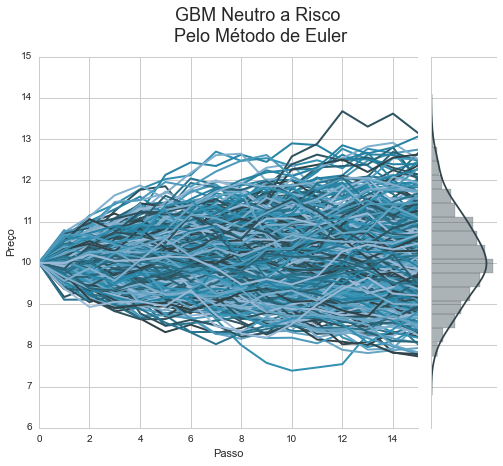

In [38]:
plot_simulations(df,
                 u"GBM Neutro a Risco\n Pelo Método de Euler",
                 d_param["f_steps"])

In [37]:
# mostra resumo estatistico do ultimo valor das simulacoes
df_descr = pd.DataFrame(df.iloc[-1, :].describe()).T
df_descr.index = ["values"]
df_descr

,count,mean,std,min,25%,50%,75%,max
values,500,10.118294,1.02204,7.732385,9.406075,10.056421,10.790151,13.141852


Como apenas troquei $r$ por $\mu$ quando modelo por Euler, parece que apenas alterei o drift da dinâmica.

### 3.4. Enfim, o apreçamento dos derivativos

Assumindo que todas as opções são do tipo Européia (só podem ser exercidas no vencimento) e não dependem da trajetória do ativo base, e utilizando o mundo neutro a risco descrito acima, preciso apenas trazer a valor presente o valor das opções em seus vencimentos. Considerando uma taxa de juros livre de risco $r$ constante no período, fico com

$V_T = e^{-r(T-t)} E^{\tilde{P}}_{t}[V(T, S_T)]$

Aplicando esta fórmula e a dinâmica neutra a risco do ativo base ao payoff do **contrato log**, segue que

\begin{equation}
\begin{aligned}
V_T &= V(T, S_T) = ln(S_T) \\
&= e^{-r(T-t)} E^{\tilde{P}}_{t}[V(T, S_T)] \\
&= e^{-r(T-t)} E^{\tilde{P}}_{t}[ln(S_T)] \\
&= e^{-r(T-t)} E^{\tilde{P}}_{t}[ln(S_t \cdot e^{ \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W^{\tilde{P}}_{T-t}})] \\
&= e^{-r(T-t)} E^{\tilde{P}}_{t}[ln(S_t)  + \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W^{\tilde{P}}_{T-t}]
\end{aligned}
\end{equation}

Como $E^{\tilde{P}}_t [\tilde{W_t}] = 0$, a equação de precificação e o [delta](http://www.investopedia.com/articles/optioninvestor/03/021403.asp) da opção (sua sensibilidade em relação à $S_t$) ficam sendo:

\begin{equation}
\begin{aligned}
V_t &= e^{-r(T-t)} \cdot (ln(S_t)  + \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t))\\
\Delta &= \frac{\partial V_t}{\partial S_t} = \frac{e^{-r(T-t)}}{S_t}
\end{aligned}
\end{equation}


In [108]:
# a classe basica para as opcoes
import numpy as np

class Derivative(object):
    '''
    A general representation of a Derivative contract. The volatility and the
    interest rate are constant
    '''
    def __init__(self, f_St, f_sigma, f_time, f_r, f_K = None):
        '''
        Initialize a Derivative object
        :param f_St: float. The price of the underline asset
        :param f_sigma: float. A non negative underline volatility
        :param f_time: float. The time remain until the expiration
        :param f_r: float. The free intereset rate
        :*param f_K: float. The strike, if applyable
        '''
        # inicia variaveis
        self.s_name = "General"
        self.f_price = 0
        self.f_delta = 0
        self.f_K = f_K
        self.f_r = f_r
        self.f_sigma = f_sigma
        # define preco e delta
        self.update(f_St, f_time)

    def update(self, f_St, f_time):
        '''
        Update the price of the Derivative contract and its Delta
        :param f_St: float. The price of the underline asset
        :param f_time: float. The time remain until the expiration
        '''
        # salva novos atributos
        self.f_St = f_St
        self.f_time = f_time
        # calcula preco e delta
        self._set_price()
        self._set_delta()
    
    def _set_price(self):
        '''
        Return the price of the contract
        '''
        raise NotImplementedError()

    def _set_delta(self):
        '''
        Return the delta of the contract
        '''
        raise NotImplementedError()
    
    def __str__(self):
        '''
        Return a string describing the option
        '''
        s = u"Um(a) {} baseado em um subjacente com preco {:.2f}"
        s += u", {:.1f}% de volatilidade, juros de {:.1f}%"
        if self.f_K:
            s += u", com Strike de {}"
            l_val = [self.s_name, self.f_St, self.f_sigma *100,
                     self.f_r*100, self.f_K, self.f_time,
                     self.f_price, self.f_delta]
        else:
            l_val = [self.s_name, self.f_St, self.f_sigma *100,
                     self.f_r*100, self.f_time, self.f_price,
                     self.f_delta]
        s += u" e vencimento em {:.2f} anos tem o preco de R$ {:.2f} "
        s += u"e Delta de {:.2f}"
        s = s.format(*l_val)
        return s
        

In [191]:
class LogContract(Derivative):
    '''
    A representation of a Log Contract
    '''
    def __init__(self, f_St, f_sigma, f_time, f_r, f_K=None):
        '''
        Initialize a LogContract object. Save all parameters as attributes
        :param f_St: float. The price of the underline asset
        :param f_sigma: float. A non negative underline volatility
        :param f_time: float. The time remain until the expiration
        :param f_r: float. The free intereset rate
        :*param f_K: float. The strike, if applyable
        '''
        # inicia variaveis da Derivativo
        super(LogContract, self).__init__(f_St=f_St,
                                          f_sigma=f_sigma,
                                          f_time=f_time,
                                          f_r=f_r,
                                          f_K=None)
        self.s_name = "Contrato Log"
    def _set_price(self):
        '''
        Return the price of the contract
        '''
        exp_r_t = np.exp(-1*self.f_r*self.f_time)
        ln_S = np.log(self.f_St)
        r_var_t = (self.f_r - (self.f_sigma**2)/2) * self.f_time
        ln_S_r_var_t = ln_S + r_var_t
        self.f_price = exp_r_t * ln_S_r_var_t

    def _set_delta(self):
        '''
        Return the delta of the contract
        '''
        exp_r_t = np.exp(-1*self.f_r*self.f_time)
        
        self.f_delta = exp_r_t / self.f_St
    

In [205]:
import pandas as pd

def plot_payoff(MyOption, d_param):
    '''
    PLot the payoff of the option at the expiration
    :param MyOption: Derivative Object. A contract/option instance
    :param d_param: dict. The initial parameter pof the MyOption
    '''
    # calcula Preco no vencimeno
    option = MyOption(**d_param)
    f_min = d_param["f_St"]*0.2
    f_max = d_param["f_St"]*1.8
    na_ST = np.linspace(f_min, f_max, 50)
    l_price = []
    for f_p in na_ST:
        # pega peco no vencimento
        option.update(f_p, 0.)
        l_price.append(option.f_price)
    # arruma dados para plotar
    df_plot = pd.DataFrame(l_price, index=na_ST)
    df_plot.columns = ["Preco"]
    # plota Precos
    ax = df_plot.plot(legend=False)
    ax.set_xlabel(u"Preço do Subjacente")
    ax.set_ylabel(u"PnL")
    s_title = u"Pay-Off no Vencimento {} {}\n"
    s_prep = "do"
    if "Opcao" in option.s_name or "Call" in option.s_name:
        s_prep = "da" 
    ax.set_title(s_title.format(s_prep, option.s_name), fontsize=18);

In [192]:
# parametros iniciais
d_param = {"f_St": 100.,  # estado inicial do ativo
           "f_r": 0.10,  # taxa de juros
           "f_sigma": 0.50,  # desvio padrao da dinamica
           "f_time": 0.5,  # tempo decorrido na simulacao (anos)
           "f_K": None  # strike (nao tem para log)
           }
# teste de codigo
x = LogContract(**d_param)
print x

Um(a) Contrato Log baseado em um subjacente com preco 100.00, 50.0% de volatilidade, juros de 10.0% e vencimento em 0.50 anos tem o preco de R$ 4.37 e Delta de 0.01


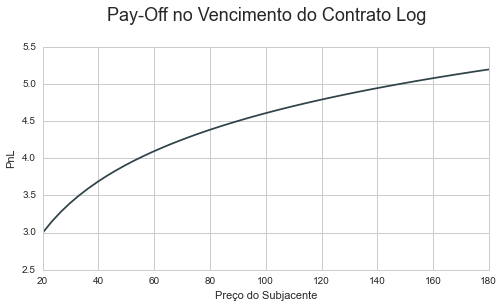

In [193]:
plot_payoff(LogContract, d_param)

Agora, precificando o **contrato log quadrático**, tenho que:

\begin{equation}
\begin{aligned}
V_T &= V(T, S_T) = (ln(S_T))^2 \\
&= e^{-r(T-t)} E^{\tilde{P}}_{t}[V(T, S_T)] \\
&= e^{-r(T-t)} E^{\tilde{P}}_{t}[(ln(S_T))^2] \\
&= e^{-r(T-t)} E^{\tilde{P}}_{t}[(ln(S_t \cdot e^{ \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W^{\tilde{P}}_{T-t}}))^2] \\
&= e^{-r(T-t)} E^{\tilde{P}}_{t}[(ln(S_t)  + \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W^{\tilde{P}}_{T-t})^2]
\end{aligned}
\end{equation}

Lembrando da propriedade do [quadrado de uma soma](http://planetmath.org/squareofsum), chego que:

\begin{equation}
\begin{aligned}
V_T &= e^{-r(T-t)} E^{\tilde{P}}_{t}[(ln(S_t)  + \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t))^2 + 2 \cdot ln(S_t)  \\ 
& \qquad \cdot \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) \cdot \sigma \cdot W^{\tilde{P}}_{T-t} + (\sigma \cdot W^{\tilde{P}}_{T-t})^2]
\end{aligned}
\end{equation}

Como $E^{\tilde{P}}_t [\tilde{W_t}] = 0$ e $E^{\tilde{P}}_t [\sigma^2 \tilde{W_t}^2] = \sigma^2 (T-t)$, então a equação e o delta ficam sendo:

\begin{equation}
\begin{aligned}
V_t &= e^{-r(T-t)} \cdot [(ln(S_t)  + \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t))^2 + \sigma^2 (T-t)]\\
\Delta &= \frac{\partial V_t}{\partial S_t} = \frac{2e^{-r(T-t)}}{S_t}[(ln(S_t)  + \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t)]
\end{aligned}
\end{equation}


In [111]:
class SquaredLogContract(Derivative):
    '''
    A representation of a Squared Log Contract
    '''
    def __init__(self, f_St, f_sigma, f_time, f_r, f_K=None):
        '''
        Initialize a SquaredLogContract object. Save all parameters as attributes
        :param f_St: float. The price of the underline asset
        :param f_sigma: float. A non negative underline volatility
        :param f_time: float. The time remain until the expiration
        :param f_r: float. The free intereset rate
        :*param f_K: float. The strike, if applyable
        '''
        # inicia variaveis da Derivativo
        super(SquaredLogContract, self).__init__(f_St=f_St,
                                                 f_sigma=f_sigma,
                                                 f_time=f_time,
                                                 f_r=f_r,
                                                 f_K=None)
        self.s_name = "Contrato Log Quadratico"
    def _set_price(self):
        '''
        Return the price of the contract
        '''
        exp_r_t = np.exp(-1*self.f_r*self.f_time)
        ln_S_r_var_t_sq = (np.log(self.f_St) + (self.f_r - (self.f_sigma**2)/2)
                           * self.f_time)**2
        var_t = self.f_sigma**2 * self.f_time
        self.f_price = exp_r_t * (ln_S_r_var_t_sq + var_t)

    def _set_delta(self):
        '''
        Return the delta of the contract
        '''
        two_exp_r_t_over_S = 2 * np.exp(-1*self.f_r*self.f_time) / self.f_St
        ln_S_r_var_t = (np.log(self.f_St) + (self.f_r - (self.f_sigma**2)/2)
                        * self.f_time)
        self.f_delta = two_exp_r_t_over_S * ln_S_r_var_t

In [112]:
# parametros iniciais
d_param = {"f_St": 100.,  # estado inicial do ativo
           "f_r": 0.10,  # taxa de juros
           "f_sigma": 0.50,  # desvio padrao da dinamica
           "f_time": 0.5,  # tempo decorrido na simulacao (anos)
           "f_K": None  # strike (nao tem para log)
           }
# teste de codigo
x = SquaredLogContract(**d_param)
print x

Um(a) Contrato Log Quadratico baseado em um subjacente com preco 100.00, 50.0% de volatilidade, juros de 10.0% e vencimento em 0.50 anos tem o preco de R$ 20.18 e Delta de 0.09


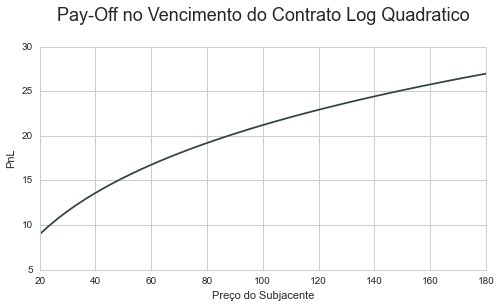

In [194]:
plot_payoff(SquaredLogContract, d_param)

Para precificar um contrato **exótico** com payoff da forma $V(T, S_T)=(S_T-K)^2$, lembrando que $K$ é o strike e, por tanto, uma constante. Segue que:

\begin{equation}
\begin{aligned}
V_T &= V(T, S_T) = (S_T-K)^2 = S_T^2 - 2K S_T + K^2\\
&= e^{-r(T-t)} E^{\tilde{P}}_{t}[V(T, S_T)] \\
&= e^{-r(T-t)} E^{\tilde{P}}_{t}[S_T^2 - 2K S_T + K^2] \\
&= e^{-r(T-t)} (E^{\tilde{P}}_{t}[S_T^2] - 2KE^{\tilde{P}}_{t}[S_T] + K^2) \\
\end{aligned}
\end{equation}

Lembrando que dado uma v.a. $X \sim N(\mu, \sigma)$, sua função geradora de momentos é da forma $E_{t}^{\tilde{P}} (e^{\lambda X}) = e^{\lambda \mu + \tfrac{1}{2} \lambda^{2} \sigma^{2}}$. Logo (checar essa passagem):

\begin{equation}
\begin{aligned}
E^{\tilde{P}}_{t}[S_T] &= S_t  \cdot E^{\tilde{P}}_{t}[e^{ \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W^{\tilde{P}}_{T-t}}]\\
&= S_t  \cdot e^{ \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \frac{\sigma^2}{2}(T - t)} \\
&= S_t  \cdot e^{r(T-t)}
\end{aligned}
\end{equation}

E também que:

\begin{equation}
\begin{aligned}
E^{\tilde{P}}_{t}[S_T^2] &= S_t^2  \cdot e^{ 2(r - \frac{\sigma^2}{2} ) \cdot (T - t) + \frac{4 \sigma^2}{2}(T - t)} \\
&= S_t^2  \cdot e^{(2r + \sigma^2)(T-t)}
\end{aligned}
\end{equation}

Logo, a equação de precificação do contrato (que tem um $K$ já fixado) e seu delta são dados por:

\begin{equation}
\begin{aligned}
V_T &= e^{-r(T-t)} (E^{\tilde{P}}_{t}[S_T^2] - 2KE^{\tilde{P}}_{t}[S_T] + K^2) \\
&= e^{-r(T-t)} (S_t^2  \cdot e^{(2r + \sigma^2)(T-t)} - 2KS_t  \cdot e^{r(T-t)} + K^2) \\
&=  S_t^2  \cdot e^{(r + \sigma^2)(T-t)} - 2KS_t + K^2 e^{-r(T-t)} \\
\Delta &= \frac{\partial V_t}{\partial S_t} = 2 S_t  \cdot e^{(r + \sigma^2)(T-t)} - 2K
\end{aligned}
\end{equation}


In [196]:
class SquaredExotic(Derivative):
    '''
    A representation of a exotic suqared contract. The Strike is given
    '''
    def __init__(self, f_St, f_sigma, f_time, f_r, f_K):
        '''
        Initialize a SquaredExotic object. Save all parameters as attributes
        :param f_St: float. The price of the underline asset
        :param f_sigma: float. A non negative underline volatility
        :param f_time: float. The time remain until the expiration
        :param f_r: float. The free intereset rate
        :param f_K: float. The strike, if applyable
        '''
        # inicia variaveis da Derivativo
        super(SquaredExotic, self).__init__(f_St=f_St,
                                            f_sigma=f_sigma,
                                            f_time=f_time,
                                            f_r=f_r,
                                            f_K=f_K)
        self.s_name = "Exotico Quadratico"
    def _set_price(self):
        '''
        Return the price of the contract
        '''
        exp_r_var_t = np.exp((self.f_r + self.f_sigma**2)*self.f_time)
        S_sq_exp_r_var_t = self.f_St**2 * exp_r_var_t
        K_sq_exp_r_t = self.f_K**2 * np.exp(-self.f_r * self.f_time)
        two_S_K = 2 * self.f_St * self.f_K
        self.f_price = S_sq_exp_r_var_t - two_S_K + K_sq_exp_r_t

    def _set_delta(self):
        '''
        Return the delta of the contract
        '''
        exp_r_var_t = np.exp((self.f_r + self.f_sigma**2)*self.f_time)
        two_K = 2 * self.f_K

        self.f_delta = 2*self.f_St * exp_r_var_t - two_K

In [197]:
# parametros iniciais
d_param = {"f_St": 100.,  # estado inicial do ativo
           "f_r": 0.10,  # taxa de juros
           "f_sigma": 0.50,  # desvio padrao da dinamica
           "f_time": 0.5,  # tempo decorrido na simulacao (anos)
           "f_K": 100  # strike (nao tem para log)
           }
# teste de codigo
x = SquaredExotic(**d_param)
print x

Um(a) Exotico Quadratico baseado em um subjacente com preco 100.00, 50.0% de volatilidade, juros de 10.0%, com Strike de 100 e vencimento em 0.50 anos tem o preco de R$ 1424.76 e Delta de 38.25


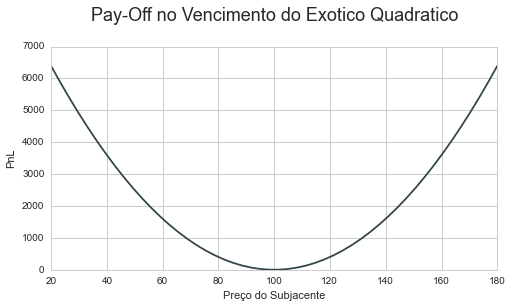

In [198]:
plot_payoff(SquaredExotic, d_param)

Resolvendo para **opção digital**:

\begin{equation}
\begin{aligned}
V_T &= V(T, S_T) = \mathbf{1}_{S_T > K} \\
&= e^{-r(T-t)} E^{\tilde{P}}_{t}[V(T, S_T)] \\
&= e^{-r(T-t)} E^{\tilde{P}}_{t}[\mathbf{1}_{S_T > K}] \\
\end{aligned}
\end{equation}

Para que $S_T>K$, tenho que:


\begin{equation}
\begin{aligned}
S_t \cdot e^{ \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W^{\tilde{P}}_{T-t}} &> K\\
\sigma \cdot W^{\tilde{P}}_{T-t} &> ln(\frac{K}{S_T}) - (r - \frac{\sigma^2}{2} ) \cdot (T - t) \\
- \frac{W^{\tilde{P}}_{T-t}}{\sqrt{T-t}} &< \left [ ln(\frac{S_T}{K}) - (r - \frac{\sigma^2}{2} ) \cdot (T - t) \right ] \cdot \frac{1}{(\sigma \sqrt{T-t})}
\end{aligned}
\end{equation}

Chamando o lado esquerdo de $\xi$ e o direito de $d2$, conclúo que :

\begin{equation}
\begin{aligned}
e^{-r(T-t)} E^{\tilde{P}}_{t}[\mathbf{1}_{S_T > K}] &= e^{-r(T-t)} Prob^{\tilde{P}}(S_T>K) = e^{-r(T-t)} Prob^{\tilde{P}}(\xi < d2)\\
V_T &= e^{-r(T-t)} N(d2) \\
\Delta &=\frac{e^{-r(T-t)} N'(d_2)}{\sigma S_t \sqrt{T-t}}
\end{aligned}
\end{equation}

Onde $N(.)$ é a CDF de uma normal padrão e $N'(.)$ é sua PDF. A derivação do delta pode ser encontrada [aqui](http://quant.stackexchange.com/questions/23267/delta-of-binary-option). É interessante notar que no vencimento, como será visto no gráfico de payoff abaixo, a opção não é diferenciável.

In [199]:
def get_d1_and_d2(f_St, f_sigma, f_time, f_r, f_K):
    '''
    Calculate the d1 and d2 parameter used in Digital and call options
    '''
    f_d2 = (np.log(f_St/f_K) - (f_r - 0.5 * f_sigma **2)*f_time)
    f_d2 /= (f_sigma * f_time**0.5)
    f_d1 = f_d2 + f_sigma*f_time**0.5
    return f_d1, f_d2

In [207]:
from scipy import stats

class DigitalOption(Derivative):
    '''
    A representation of a Digital Option.
    '''
    def __init__(self, f_St, f_sigma, f_time, f_r, f_K):
        '''
        Initialize a DigitalOption object. Save all parameters as attributes
        :param f_St: float. The price of the underline asset
        :param f_sigma: float. A non negative underline volatility
        :param f_time: float. The time remain until the expiration
        :param f_r: float. The free intereset rate
        :param f_K: float. The strike, if applyable
        '''
        # inicia variaveis da Derivativo
        super(DigitalOption, self).__init__(f_St=f_St,
                                            f_sigma=f_sigma,
                                            f_time=f_time,
                                            f_r=f_r,
                                            f_K=f_K)
        self.s_name = "Opcao Digital"
    def _set_price(self):
        '''
        Return the price of the contract
        '''
        f_d1, f_d2 = get_d1_and_d2(self.f_St, self.f_sigma, self.f_time,
                                   self.f_r, self.f_K)
        exp_r_t = np.exp(-self.f_r * self.f_time)
        cdf_d2 = stats.norm.cdf(f_d2, 0., 1.)
        self.f_price = exp_r_t * cdf_d2

    def _set_delta(self):
        '''
        Return the delta of the contract
        '''
        f_d1, f_d2 = get_d1_and_d2(self.f_St, self.f_sigma, self.f_time,
                                   self.f_r, self.f_K)
        exp_r_t = np.exp(-self.f_r * self.f_time)
        pdf_d2 = stats.norm.pdf(f_d2, 0., 1.)
        sig_S_sqtr_t = self.f_sigma * self.f_St * (self.f_time**0.5)
        self.f_delta = exp_r_t * pdf_d2 / sig_S_sqtr_t

In [208]:
# parametros iniciais
d_param = {"f_St": 100.,  # estado inicial do ativo
           "f_r": 0.10,  # taxa de juros
           "f_sigma": 0.50,  # desvio padrao da dinamica
           "f_time": 0.5,  # tempo decorrido na simulacao (anos)
           "f_K": 100  # strike (nao tem para log)
           }
# teste de codigo
x = DigitalOption(**d_param)
print x

Um(a) Opcao Digital baseado em um subjacente com preco 100.00, 50.0% de volatilidade, juros de 10.0%, com Strike de 100 e vencimento em 0.50 anos tem o preco de R$ 0.49 e Delta de 0.01


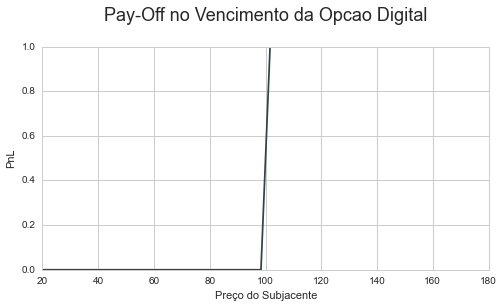

In [203]:
plot_payoff(DigitalOption, d_param)

E por fim,  o payof  da **call européia** pode ser mostrado ser da forma:

\begin{equation}
\begin{aligned}
V_T &= V(T, S_T) = max(S_T-K, 0) \\
&= (S_T-K)\mathbf{1}_{S_T > K} \\
&= S_T\mathbf{1}_{S_T > K}-K\mathbf{1}_{S_T > K} \\
\end{aligned}
\end{equation}

O segundo termo, $K\mathbf{1}_{S_T > K}$, equivale ao payoff de uma opção digital multiplicado por K. Já o primeiro termo equivale ao payoff da *share digital option*, que não será demonstrado aqui, porém, para um ativo que não pague dividendos, é da forma $S_T N(d1)$. $d1$ pode ser mostrado como sendo da forma $d1 = d2 + \sigma \sqrt{(T-t)}$. Assim, a fórmula de precificação e o delta ficam sendo:

\begin{equation}
\begin{aligned}
V_T &= S_T  N(d1)- K e^{-r(T-t)} N(d2) \\
\Delta &= \frac{\partial V_t}{\partial S_t} = N(d1)
\end{aligned}
\end{equation}

In [184]:
class EuropianCall(Derivative):
    '''
    A representation of a Europian Call Option
    '''
    def __init__(self, f_St, f_sigma, f_time, f_r, f_K):
        '''
        Initialize a EuropianCall object. Save all parameters as attributes
        :param f_St: float. The price of the underline asset
        :param f_sigma: float. A non negative underline volatility
        :param f_time: float. The time remain until the expiration
        :param f_r: float. The free intereset rate
        :param f_K: float. The strike, if applyable
        '''
        # inicia variaveis da Derivativo
        super(EuropianCall, self).__init__(f_St=f_St,
                                            f_sigma=f_sigma,
                                            f_time=f_time,
                                            f_r=f_r,
                                            f_K=f_K)
        self.s_name = "Call Europeia"
    def _set_price(self):
        '''
        Return the price of the contract
        '''
        f_d1, f_d2 = get_d1_and_d2(self.f_St, self.f_sigma, self.f_time,
                                   self.f_r, self.f_K)
        exp_r_t = np.exp(-self.f_r * self.f_time)
        S_cdf_d1 = self.f_St * stats.norm.cdf(f_d1, 0., 1.)
        K_cdf_d2 = self.f_K * stats.norm.cdf(f_d2, 0., 1.)
        
        self.f_price = S_cdf_d1 - K_cdf_d2 * exp_r_t

    def _set_delta(self):
        '''
        Return the delta of the contract
        '''
        f_d1, f_d2 = get_d1_and_d2(self.f_St, self.f_sigma, self.f_time,
                                   self.f_r, self.f_K)
        cdf_d1 = stats.norm.cdf(f_d1, 0., 1.)
        self.f_delta = cdf_d1

In [185]:
# parametros iniciais
d_param = {"f_St": 100.,  # estado inicial do ativo
           "f_r": 0.10,  # taxa de juros
           "f_sigma": 0.50,  # desvio padrao da dinamica
           "f_time": 0.5,  # tempo decorrido na simulacao (anos)
           "f_K": 100  # strike (nao tem para log)
           }
# teste de codigo
x = EuropianCall(**d_param)
print x

Um(a) Call Europeia baseado em um subjacente com preco 100.00, 50.0% de volatilidade, juros de 10.0%, com Strike de 100 e vencimento em 0.50 anos tem o preco de R$ 16.23 e Delta de 0.65


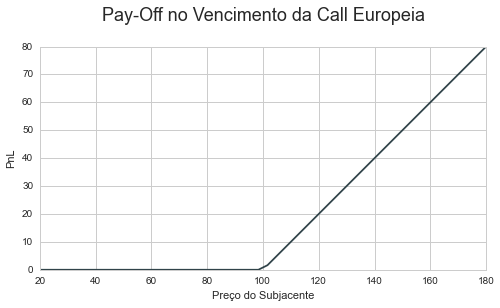

In [206]:
plot_payoff(EuropianCall, d_param)

## 3. Replicando o Portfólio

Como declarado na seção um, a intenção aqui é implementar uma estratégia dinâmica de hedging auto-financiável que replique o payoff de um dado derivativo. Assim, o valor de um portfólio $\Pi_t$ pode ser escrito como

$$\Pi_t = \Delta(S_t, t) S_t + \varphi (S_t, t) B_t$$

Onde $\Delta(S_t, t)$ é a quantidade aplicada no subjacente em um dado preço $S_t$ no momento $t$. Logo $\Delta(S_t, t) S_t$ é o valor monetário aplicado no subjacente. A mesma lógica segue $\varphi (S_t, t)$, que é a quantidade aplicada em um ativo livre de risco (em um *Bond*, por exemplo). Porém, no caso desta trabalho, o $B_t$ será igual a $1$, pois $\varphi (S_t, t) B_t$ corresponde ao valor monetário tomado ou aplicado na taxa livre de risco. Como se quer que este portfólio seja igual ao valor do derivativo, tenho que:

\begin{equation}
\begin{aligned}
\Pi_t &= V_t \\
\Delta(S_t, t) S_t + \varphi (S_t, t) \cdot 1 &= V_t \\
\varphi (S_t, t) &= V_t - \Delta(S_t, t) S_t
\end{aligned}
\end{equation}


In [ ]:
def box_plot_err(MyOption, df):
    '''
    Plot a boxplot of the hedging erro of the strategy passed
    '''
    # plota dados
    df2 = df.copy()
    df2 = df2.assign(Err=df2['Vt'] - df2['Ht'])
    option = MyOption(1., 1., 1., 1., 1.)
    print df2
    ax = sns.boxplot(x='N', y='Err', data=df2)
    ax.set_ylabel('$V_T - H_T$')
    ax.set_xlabel(u'Número de Rebalanceamentos')
    # define titutlos
    s_title = u'Box-Plot do Erro de Hedging na Replicação\n {} {}\n'
    s_prep = 'do'
    if 'Opcao' in option.s_name or 'Call' in option.s_name:
        s_prep = 'da'
    # insere titulo
    ax.set_title(s_title, fontsize=16, y=1.03)

In [ ]:
def plot_payoff_all_simulations(MyOption, df):
    '''
    Plot a payoff scatter plot with the final returns of a stochastic
    simulation of a replicationg strategy using different rebalancing
    frequencies. Compare to the last price of the option/contract simulated
    :param MyOption: Derivative Object. A contract/option instance
    :param df: dataframe. The output of strategy the simulation
    '''
    # exlui os valores do ativo que estiverem nos 2 porcento superior da distr
    f_98perc = np.percentile(df.St, 98)
    df2 = df[(df.St <= f_98perc)]
    f_max = df2.St.max()
    option = MyOption(1., 1., 1., 1., 1.)
    # plota grafico
    g = sns.FacetGrid(df2, col="N", col_wrap=3, margin_titles=True,
                      sharex=False, size=3, aspect=1.3)
    g.map(plt.scatter, 'St', 'Ht', s=2, linewidth=.0, edgecolor='white',
          alpha=0.6, label=u'$H(T)$')
    g.map(plt.scatter, 'St', 'Vt', s=3, linewidth=.0, edgecolor='white',
          color='g', label=u'$V(T)$')
    # define titutlos
    s_title = u'Pay-Off da Simulacao {} {}\n'
    s_prep = 'do'
    if 'Opcao' in option.s_name or 'Call' in option.s_name:
        s_prep = 'da'
    g.fig.suptitle(s_title.format(s_prep, option.s_name), fontsize=16, y=1.03)
    g.despine(left=True).add_legend()
    g.set(xlim=(5., f_max + 5))

In [301]:
import time

def replicate_portfolio(i_nsiml, MyOption, d_param):
    '''
    Simulate portfolio when selling a given option/contract and using a
    money market account and the the underline asset to replicate it
    Return a dataframe with the last observed value of the derivative,
    de asset and the strategy
    :param MyOption: Derivative Object. A contract/option instance
    :param i_nsiml: integer. the number of paths contructed
    :param d_param: dictionary. The parameter of the simulation
    '''
    st = time.time()
    # Crio objeto para simulacao
    gbm = GBM_By_Euler(f_s0=d_param['f_St'],
                       f_mu=d_param['f_mu'],
                       f_sigma=d_param['f_sigma'],
                       f_time=d_param['f_time'],
                       f_steps=d_param['f_steps'])
    # crio opcao
    option = MyOption(**d_par_opt)
    f_dt = d_param['f_time'] / d_param['f_steps']
    # crio i_nsiml caminhos com f_steps simulacoes e calculo
    # os deltas e phis em cada passo
    d = {"St": [], "Vt": [], "Delta": [],
         "PhiB": [], "DeltaS": [], "Ht": []}
    d_aux = {"St": [], "Vt": [], "Delta": [],
             "PhiB": [], "DeltaS": [], "Ht": []}
    for idx in range(int(i_nsiml * (1 + gbm.f_steps))):
        if gbm.current_step==gbm.f_steps:
            # terminou este path. Comeca outro
            for s_key in ["St", "Vt", "Delta", "PhiB", "DeltaS", "Ht"]:
                # d[s_key].append(d_aux[s_key])
                d[s_key].append(d_aux[s_key][-1])
                d_aux[s_key] = []
        d_aux["St"].append(gbm())
        # calculo tempo para vencimento
        f_tnow = d_param['f_time'] - gbm.current_step*f_dt
        # calculo preco da opcao
        option.update(d_aux["St"][-1], f_tnow)
        d_aux["Vt"].append(option.f_price)
        d_aux["Delta"].append(option.f_delta)
        ## Calculo posicao no ativo para portfolio replicante
        d_aux["DeltaS"].append(d_aux["St"][-1] * d_aux["Delta"][-1])
        # calculo valor no money market account
        if gbm.current_step == 0:
            d_aux["PhiB"].append(d_aux["Vt"][-1] - d_aux["DeltaS"][-1])
        else:
            # carrego juros da aplicacao anterior
            f_aux = d_aux["PhiB"][-1] * (1 + f_dt * d_param['f_r'])
            # pago delta hedge
            f_chg_delta = d_aux["Delta"][-1] - d_aux["Delta"][-2]
            f_chg_delta_s = f_chg_delta * d_aux["St"][-1]
            d_aux["PhiB"].append(f_aux - f_chg_delta_s)
        # calculo valor da estrategia
        d_aux["Ht"].append(d_aux["DeltaS"][-1] + d_aux["PhiB"][-1])
        
    # guardo ultimo path
    for s_key in ["St", "Vt", "Delta", "PhiB", "DeltaS", "Ht"]:
        # d[s_key].append(d_aux[s_key])
        d[s_key].append(d_aux[s_key][-1])
        d_aux[s_key] = []
    
    # monto tabela
    
    # imprimo tempo e simulacoes
    print ("\nNumero de sorteios: {}".format(idx + 1))
    print ("Levou {:0.2f} segundos".format(time.time() - st))
    # crio dataframe com os passos nas linhas e as simulacoes nas colunas
    df = pd.DataFrame(d)
    df = df.loc[:, ["St", "Ht", "Vt"]]
    return df

Primeiro testo para **Call Européia**:

In [3]:
import simulation; reload(simulation)
from simulation import *

In [71]:
i_nsiml = 5000
d = {}
st = time.time()
for N in [15, 30, 52, 90, 180, 360]:
    d_param = {"f_St": 100.,  # estado inicial do ativo
               "f_r": 0.10,  # taxa de juros
               "f_sigma": 0.50,  # desvio padrao da dinamica
               "f_time": 0.5,  # tempo decorrido na simulacao (anos)
               "f_K": 100,  # strike (nao tem para log),
               "f_steps": N, # quantidade de passos dado entre a e f_time
               "f_mu": 0.12  # media da dinamica
               }
    d[N] = replicate_portfolio(i_nsiml, EuropianCall, d_param)
print "\nTOTAL: {:.2f} segundos".format(time.time() - st)


Numero de sorteios: 80000
Levou 33.51 segundos

Numero de sorteios: 155000
Levou 65.04 segundos

Numero de sorteios: 265000
Levou 111.32 segundos

Numero de sorteios: 455000
Levou 192.16 segundos

Numero de sorteios: 905000
Levou 382.64 segundos

Numero de sorteios: 1805000
Levou 765.04 segundos
TOTAL: -1549.78 segundos


In [127]:
# salva resultado
for idx, N in enumerate([15, 30, 52, 90, 180, 360]):
    df_aux = d[N].copy()
    df_aux["N"] = None
    df_aux["N"] = N
    if idx==0:
        df = df_aux 
    else:
        df = pd.concat([df, df_aux], ignore_index=True)
df.to_csv("data/europian_call.tsv", sep="\t")

In [99]:
df.head()

,St,Ht,Vt,N
0,69.394339,-1.161429,0.000000,15
1,64.692817,-5.424572,0.000000,15
2,109.271865,11.553293,9.271865,15
3,73.776944,-1.299496,0.000000,15
4,64.956719,1.049455,0.000000,15


Abaixo vou plotar os gráficos dos payoff da estratégia utilizando várias frequências de rebalanceamentos. Como pode-se notar, a quantidade de rebalanceamentos reduz a erro de hedging da estratégia.

In [230]:
df = pd.read_csv("data/europian_call.tsv", sep="\t")

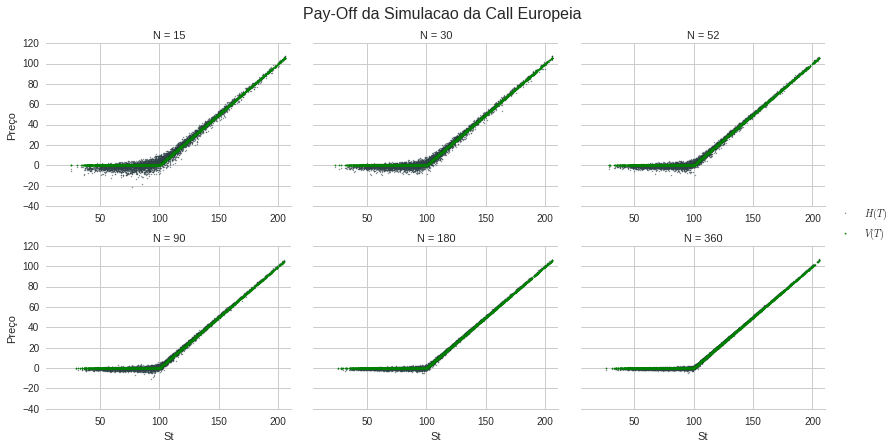

In [233]:
plot_payoff_all_simulations(EuropianCall, df);

Outro maneira de visualiar estes dados é através do [boxplot](https://en.wikipedia.org/wiki/Box_plot) da distribuição dos resultados de cada rebalanceamento. A "caixa" marca o segundo e o terceiro quartil, enquanto a "sombra" marca o primeiro e o quarto quártil (calculados com o [intervalo interquartil](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/)). Os pontos além dessas marcas são os dados considerados anormais.

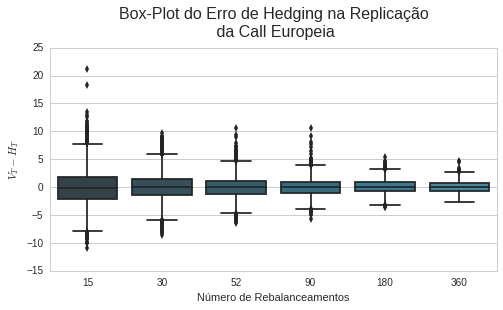

In [157]:
box_plot_err(EuropianCall, df)

Agora testo para o **Contrato Log**:

In [4]:
i_nsiml = 5000
d = {}
st = time.time()
for N in [15, 30, 52, 90, 180, 360]:
    d_param = {"f_St": 100.,  # estado inicial do ativo
               "f_r": 0.10,  # taxa de juros
               "f_sigma": 0.50,  # desvio padrao da dinamica
               "f_time": 0.5,  # tempo decorrido na simulacao (anos)
               "f_K": 100,  # strike (nao tem para log),
               "f_steps": N, # quantidade de passos dado entre a e f_time
               "f_mu": 0.12  # media da dinamica
               }
    d[N] = replicate_portfolio(i_nsiml, LogContract, d_param)
print "\nTOTAL: {:.2f} segundos".format(time.time() - st)


Numero de sorteios: 80000
Levou 1.48 segundos

Numero de sorteios: 155000
Levou 2.65 segundos

Numero de sorteios: 265000
Levou 4.77 segundos

Numero de sorteios: 455000
Levou 8.01 segundos

Numero de sorteios: 905000
Levou 15.92 segundos

Numero de sorteios: 1805000
Levou 31.23 segundos

TOTAL: 64.16 segundos


In [159]:
# salva resultado
for idx, N in enumerate([15, 30, 52, 90, 180, 360]):
    df_aux = d[N].copy()
    df_aux["N"] = None
    df_aux["N"] = N
    if idx==0:
        df = df_aux 
    else:
        df = pd.concat([df, df_aux], ignore_index=True)
df.to_csv("data/log_contract.tsv", sep="\t")

In [160]:
df.head()

,St,Ht,Vt,N
0,84.438493,4.448861,4.436023,15
1,66.722433,4.178852,4.200541,15
2,101.137689,4.630018,4.616483,15
3,76.064111,4.310630,4.331577,15
4,84.902716,4.444118,4.441506,15


Ploto os payoff por rebalanceamento:

In [234]:
df = pd.read_csv("data/log_contract.tsv", sep="\t")

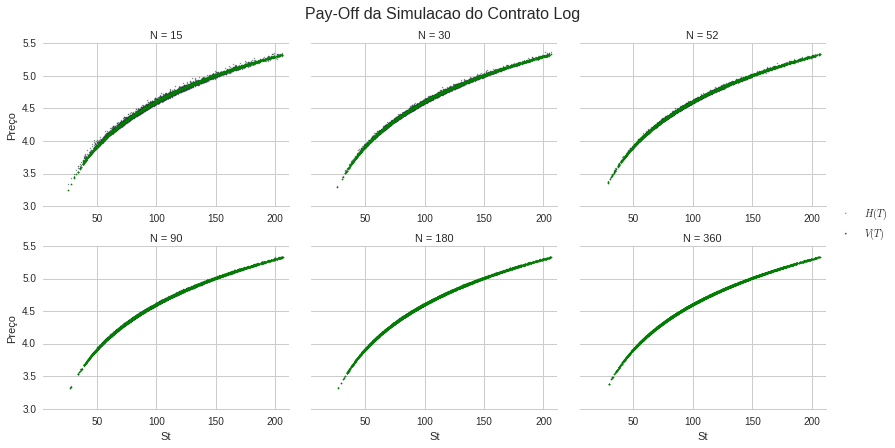

In [235]:
plot_payoff_all_simulations(LogContract, df);

E a dirtribuição dos resultados:

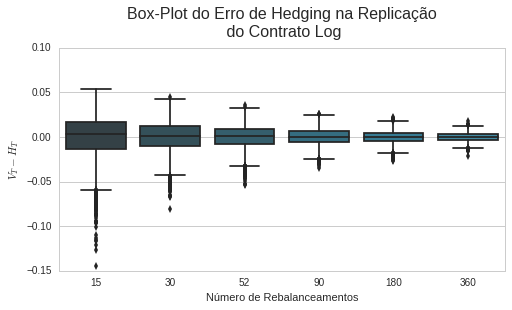

In [162]:
box_plot_err(LogContract, df)

Testo para o **Contrato Log Quadrático**:

In [163]:
i_nsiml = 5000
d = {}
st = time.time()
for N in [15, 30, 52, 90, 180, 360]:
    d_param = {"f_St": 100.,  # estado inicial do ativo
               "f_r": 0.10,  # taxa de juros
               "f_sigma": 0.50,  # desvio padrao da dinamica
               "f_time": 0.5,  # tempo decorrido na simulacao (anos)
               "f_K": 100,  # strike (nao tem para log),
               "f_steps": N, # quantidade de passos dado entre a e f_time
               "f_mu": 0.12  # media da dinamica
               }
    d[N] = replicate_portfolio(i_nsiml, SquaredLogContract, d_param)
print "\nTOTAL: {:.2f} segundos".format(time.time() - st)


Numero de sorteios: 80000
Levou 2.41 segundos

Numero de sorteios: 155000
Levou 4.60 segundos

Numero de sorteios: 265000
Levou 7.81 segundos

Numero de sorteios: 455000
Levou 13.41 segundos

Numero de sorteios: 905000
Levou 26.79 segundos

Numero de sorteios: 1805000
Levou 52.63 segundos

TOTAL: 107.70 segundos


In [164]:
# salva resultado
for idx, N in enumerate([15, 30, 52, 90, 180, 360]):
    df_aux = d[N].copy()
    df_aux["N"] = None
    df_aux["N"] = N
    if idx==0:
        df = df_aux 
    else:
        df = pd.concat([df, df_aux], ignore_index=True)
df.to_csv("data/sqr_log_contract.tsv", sep="\t")

In [165]:
df.head()

,St,Ht,Vt,N
0,103.325918,21.589219,21.510007,15
1,95.900611,20.767444,20.823820,15
2,175.906013,26.901040,26.728381,15
3,68.132277,18.407751,17.820649,15
4,179.194095,26.907671,26.920216,15


Os payoffs:

In [236]:
df = pd.read_csv("data/sqr_log_contract.tsv", sep="\t")

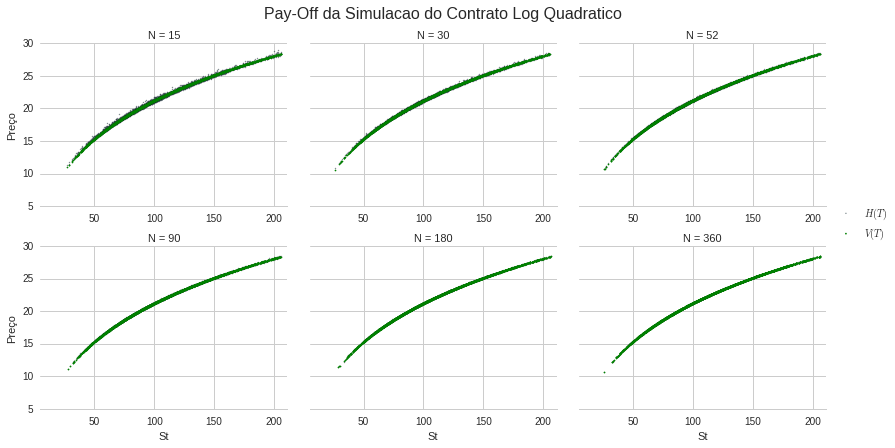

In [237]:
plot_payoff_all_simulations(SquaredLogContract, df);

E o boxplot:

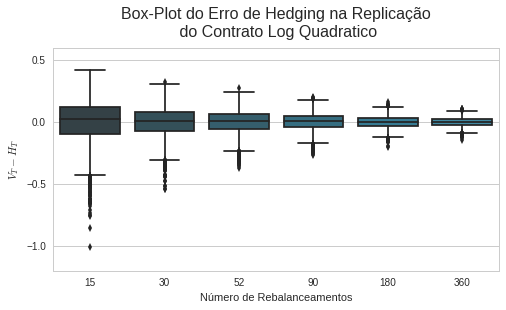

In [167]:
box_plot_err(SquaredLogContract, df)

Testo para o **Contrato Quadrático**:

In [168]:
i_nsiml = 5000
d = {}
st = time.time()
for N in [15, 30, 52, 90, 180, 360]:
    d_param = {"f_St": 100.,  # estado inicial do ativo
               "f_r": 0.10,  # taxa de juros
               "f_sigma": 0.50,  # desvio padrao da dinamica
               "f_time": 0.5,  # tempo decorrido na simulacao (anos)
               "f_K": 100,  # strike (nao tem para log),
               "f_steps": N, # quantidade de passos dado entre a e f_time
               "f_mu": 0.12  # media da dinamica
               }
    d[N] = replicate_portfolio(i_nsiml, SquaredExotic, d_param)
print "\nTOTAL: {:.2f} segundos".format(time.time() - st)


Numero de sorteios: 80000
Levou 2.29 segundos

Numero de sorteios: 155000
Levou 4.29 segundos

Numero de sorteios: 265000
Levou 7.34 segundos

Numero de sorteios: 455000
Levou 12.54 segundos

Numero de sorteios: 905000
Levou 24.83 segundos

Numero de sorteios: 1805000
Levou 49.41 segundos

TOTAL: 100.76 segundos


In [169]:
# salva resultado
for idx, N in enumerate([15, 30, 52, 90, 180, 360]):
    df_aux = d[N].copy()
    df_aux["N"] = None
    df_aux["N"] = N
    if idx==0:
        df = df_aux 
    else:
        df = pd.concat([df, df_aux], ignore_index=True)
df.to_csv("data/sqr_exotic.tsv", sep="\t")

In [170]:
df.head()

,St,Ht,Vt,N
0,64.238810,798.673830,1278.862732,15
1,108.276059,-566.655644,68.493146,15
2,150.907499,3303.042439,2591.573440,15
3,152.165503,3031.369906,2721.239666,15
4,129.185981,988.166245,851.821490,15


Os payoffs:

In [243]:
df = pd.read_csv("data/sqr_exotic.tsv", sep="\t")

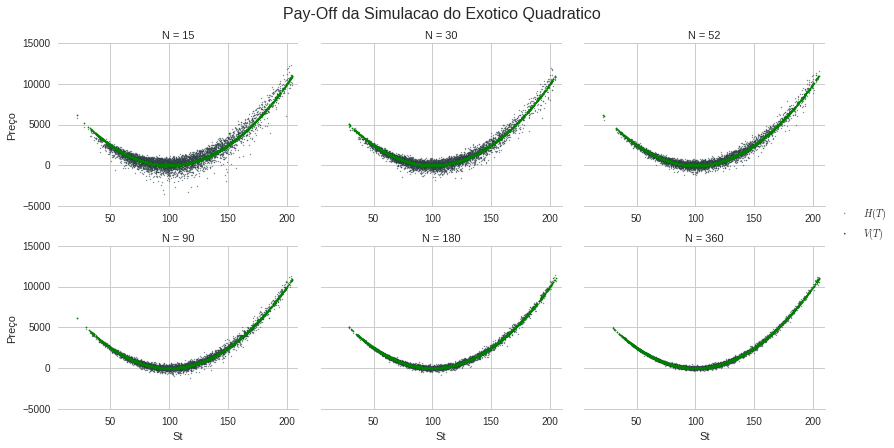

In [244]:
plot_payoff_all_simulations(SquaredExotic, df);

E o boxplot:

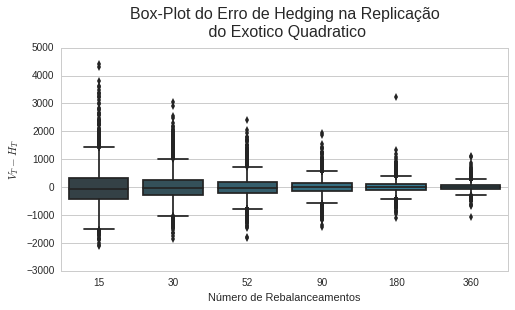

In [245]:
box_plot_err(SquaredExotic, df)

Por fim, a **Opção Digital**:

In [8]:
import simulation; reload(simulation)
from simulation import *

In [9]:
i_nsiml = 5000
d = {}
st = time.time()
for N in [15, 30, 52, 90, 180, 360]:
    d_param = {"f_St": 100.,  # estado inicial do ativo
               "f_r": 0.10,  # taxa de juros
               "f_sigma": 0.50,  # desvio padrao da dinamica
               "f_time": 0.5,  # tempo decorrido na simulacao (anos)
               "f_K": 100,  # strike (nao tem para log),
               "f_steps": N, # quantidade de passos dado entre a e f_time
               "f_mu": 0.12  # media da dinamica
               }
    d[N] = replicate_portfolio(i_nsiml, DigitalOption, d_param)
print "\nTOTAL: {:.2f} segundos".format(time.time() - st)


Numero de sorteios: 80000
Levou 15.76 segundos

Numero de sorteios: 155000
Levou 30.62 segundos

Numero de sorteios: 265000
Levou 52.35 segundos

Numero de sorteios: 455000
Levou 89.61 segundos

Numero de sorteios: 905000
Levou 181.42 segundos

Numero de sorteios: 1805000
Levou 353.03 segundos

TOTAL: 722.83 segundos


In [10]:
# salva resultado
for idx, N in enumerate([15, 30, 52, 90, 180, 360]):
    df_aux = d[N].copy()
    df_aux["N"] = None
    df_aux["N"] = N
    if idx==0:
        df = df_aux 
    else:
        df = pd.concat([df, df_aux], ignore_index=True)
df.to_csv("data/digital_opt.tsv", sep="\t")

Os payoffs:

In [ ]:
df = pd.read_csv("data/digital_opt.tsv", sep="\t")

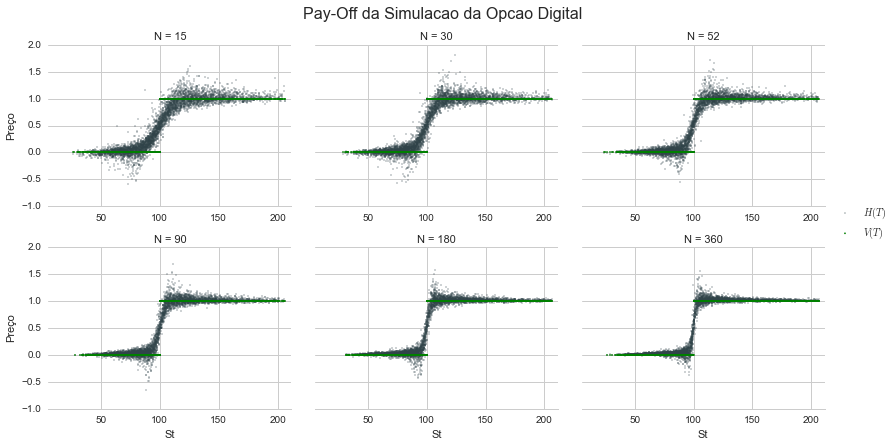

In [11]:
plot_payoff_all_simulations(DigitalOption, df);

E o boxplot:

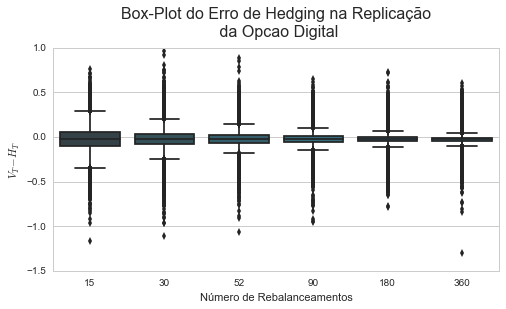

In [12]:
box_plot_err(DigitalOption, df)


## 4. Conclusão

## 5. Últimas Considerações

_Style notebook and change matplotlib defaults_

In [1]:
#loading style sheet
from IPython.core.display import HTML
HTML(open('ipython_style.css').read())

In [2]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("PuBuGn_d", 10))